## 🧪 Simulación_con_inserción.ipynb

**Autor:** Johanna Atenea Carreon Baltazar  
**Contacto:** johannaatenea13@gmail.com  
**Fecha de última modificación:** junio de 2025

---

### 🎯 Objetivo

Simular genomas artificiales de cianobacterias para evaluar si la distribución observada de genes de familias expandidas en los genomas reales podría explicarse por una distribución **aleatoria** de genes de familias génicas expandidas.  
La idea es generar 29 genomas ficticios con características similares a los genomas reales del estudio (tamaño y número de genes de familias expandidas) y analizar si la **estructura de genes de familias expandidas** difiere de lo observado en los datos reales.

---

### ⚙️ Descripción general

1. **Cálculo de estadísticas reales**:  
   Se calcula la media del tamaño en medidó en número de genes y la media del número de genes de familias expandidas por genoma, con base en los datos reales.

2. **Simulación de genomas ficticios**:  
   Se generan 29 genomas artificiales con el mismo número de posiciones (genes) que el promedio observado. En cada uno, se insertan genes de familias expandidas distribuidos de forma **uniforme aleatoria**.

3. **Cálculo de distancias**:  
   Se repiten los cálculos de distancias entre genes duplicados, como en los notebooks `Diferencias_entre_duplicados_en_num_genes.ipynb` y `Diferencias_entre_duplicados_en_pb.ipynb`, pero ahora sobre los genomas simulados.

4. **Visualización**:  
   Se construyen **histogramas, ajustes estadísticos y QQ-plots** tanto para los datos sin transformar como para datos con **transformación logarítmica**, permitiendo comparar la estructura simulada con la observada.

---

### 📥 Entradas requeridas

- Valores promedio de:
  - Tamaño genómico (kb)
  - Número de genes duplicados por genoma (de familias expandidas)

---

### 📤 Salidas generadas

- Genomas simulados con genes duplicados distribuidos aleatoriamente
- Histogramas de distancias entre duplicados
- Ajustes de distribuciones a los datos simulados
- Comparaciones visuales entre simulaciones y datos reales mediante histogramas y QQ-plots

---

### 🧰 Librerías requeridas

```python
import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from scipy import stats
from scipy.stats import johnsonsu, kstest


In [3]:
import pickle
from collections import Counter
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Resultados con k-means

De acuerdo a los resultados obtenidos cuando se uso K-means para la identificación de genes secundarios, se obtuvo total de 871 genes copia y una media de 33 genes secundarios por genoma.
De manera similar con este criterio se obtuvo 65  genes primarios como media por genoma


### Resultados del ajuste de distribuciones
Los resultados para las diferencias entre genes duplicados usando K-means son los siguientes:

| Distribución | AIC      | KS-Statistic | KS-pvalue | Parámetros                      |
|--------------|----------|--------------|-----------|---------------------------------|
| gamma        | 10754.60 | 0.0415       | 0.1025    | [0.691, 0.000, 303.141]         |
| weibull_min  | 10765.16 | 0.0498       | 0.0278    | [0.796, 0.000, 185.855]         |
| expon        | 10833.53 | 0.0906       | 0.0000    | [1.000, 208.611]                |
| lognorm      | 10929.79 | 0.0788       | 0.0000    | [1.301, -6.989, 111.459]        |
Como se observa la única distribución aceptable para modelar las diferencias es la gamma.

## Resultados con umbrales

De acuerdo a los resultados obtenidos cuando se uso el criterio de umbrales para la identificación de genes secundarios, se obtuvo total de 1232 genes copia y una media de 47  genes secundarios por genoma.
De manera similar con este criterio se obtuvo 50 genes primarios como media por genoma
### Resultados del ajuste de distribuciones
Los resultados de acuerdo al ajuste para el histograma de la diferencia entre genes duplicados contados en número de genes, fueron los siguientes:

| Distribución | AIC       | KS-Statistic | KS-pvalue | Parámetros                       |
|--------------|-----------|--------------|-----------|----------------------------------|
| gamma        | 14692.99  | 0.0247       | 0.4330    | [0.798, 0.0, 182.017]            |
| weibull_min  | 14698.80  | 0.0297       | 0.2220    | [0.873, 0.0, 136.058]            |
| expon        | 14718.73  | 0.0656       | 0.0000    | [1.0, 144.299]                   |
| lognorm      | 14873.86  | 0.0560       | 0.0008    | [1.154, -6.982, 87.555]          |


Como se puede observar, los modelos aceptados fueron la distribución gamma en primer lugar y en segundo la distribución weibull_min, por tanto, se usará esta para modelar la inserción de los genes duplicados en la simulación.

## Estadísticas de número de genes por genoma

In [4]:
ruta = 'numero_de_genes.csv'
numero_de_genes = pd.read_csv("numero_de_genes.csv", delimiter=',')
print(numero_de_genes.head())

    genome_id  number_of_genes
0   103690.82             5854
1  1472755.90             7399
2  1618022.90             7179
3  1647413.14             5966
4  1751286.15             5882


In [5]:
# Calcular la media del número de genes por genoma
media_genes = numero_de_genes['number_of_genes'].mean()
print(f"Media de genes por genoma: {media_genes:.2f}")

Media de genes por genoma: 6726.90


## Simular una población de cianobacterias por inserción

In [6]:
# Funciones del primer código
def simulador_de_genes(numero_genes):
    genoma = [f"g_{i+1}" for i in range(numero_genes)]
    return genoma

def insertar_genes_aleatoriamente(genoma, genes_a_insertar):
    for gene in genes_a_insertar:
        insert_index = np.random.randint(0, len(genoma) + 1)
        genoma.insert(insert_index, gene)

def genes_duplicados_azar(submatriz, genoma):
    genes_a_duplicar = [f"{gen}.2" for gen in submatriz]  # usa todos
    insertar_genes_aleatoriamente(genoma, genes_a_duplicar)

# Función para seleccionar genes (del primer código)
def seleccionar_genes(genoma, numero_genes_numerados):
    indices = np.random.choice(len(genoma), size=numero_genes_numerados, replace=False)
    submatriz = [genoma[i] for i in indices]
    return submatriz, indices

In [7]:
# Iniciar la población de cianobacterias con genomas construidos del primer código
def inicializar_poblacion(numero_genes, num_especies, cantidad_de_genes_duplicados):
    especies = []
    for _ in range(num_especies):
        genoma = simulador_de_genes(numero_genes)  # Crea un genoma con genes únicos
        submatriz, _ = seleccionar_genes(genoma, cantidad_de_genes_duplicados)
        genes_duplicados_azar(submatriz, genoma)  # Duplica genes en el genoma
        especies.append(genoma)
    return especies

## Parámetros
numero_genes = 6726
num_especies = 29
cantidad_de_genes_duplicados = 33
poblacion_inserción = inicializar_poblacion(numero_genes, num_especies, cantidad_de_genes_duplicados)
array = poblacion_inserción[9]
#print(array)

In [8]:
# Crear diccionario con posiciones de genes duplicados
diccionario_duplicados = {}

for i, genoma in enumerate(poblacion_inserción):
    clave = f"genoma_{i+1}"
    posiciones = [j for j, gen in enumerate(genoma) if gen.endswith('.2')]
    diccionario_duplicados[clave] = posiciones

# Guardar el diccionario en un archivo .pkl
with open('posiciones_duplicados_insercion.pkl', 'wb') as f:
    pickle.dump(diccionario_duplicados, f)



In [9]:
print(diccionario_duplicados)

{'genoma_1': [62, 89, 548, 810, 823, 849, 1650, 1761, 1878, 1948, 1953, 2277, 2491, 2690, 3079, 3152, 3312, 3806, 4158, 4162, 4249, 4359, 4453, 4776, 4779, 4785, 4807, 4829, 4935, 4988, 5339, 6084, 6533], 'genoma_2': [103, 363, 649, 682, 1412, 1415, 1753, 1852, 1899, 2248, 2326, 2777, 2979, 3134, 3147, 3429, 3795, 4270, 4474, 4586, 5176, 5190, 5576, 5664, 5887, 5900, 5935, 5942, 5987, 6060, 6107, 6421, 6602], 'genoma_3': [24, 149, 409, 568, 986, 1496, 1594, 1715, 1842, 1922, 1931, 2050, 2071, 2546, 2786, 3094, 3237, 3329, 3375, 3462, 3738, 3742, 4344, 4374, 4481, 5012, 5028, 5414, 5505, 5881, 5999, 6166, 6329], 'genoma_4': [42, 136, 157, 707, 1024, 1077, 1135, 1202, 1338, 1752, 1942, 2616, 3038, 3256, 3361, 3376, 3538, 3775, 3903, 3954, 4291, 4422, 4504, 4585, 4787, 4791, 5358, 5724, 5986, 6576, 6637, 6657, 6676], 'genoma_5': [569, 809, 820, 831, 1259, 1904, 1987, 2050, 2178, 2526, 2889, 3123, 3155, 3178, 3895, 4230, 4589, 4630, 4643, 4755, 4921, 5031, 5059, 5066, 5152, 5422, 5453, 553

## Calcular diferencias entre genes duplicados

### Inserción

In [10]:
# Función para calcular las diferencias con circularidad
num_genes_mas_duplicados = numero_genes+33
def calcular_diferencias_circulares(posiciones, num_genes):
    posiciones_ordenadas = sorted(posiciones)
    diferencias = []
    for i in range(1, len(posiciones_ordenadas)):
        diferencia = (posiciones_ordenadas[i] - posiciones_ordenadas[i - 1])
        diferencias.append(diferencia)
    # Circularidad: entre último y primero
    diferencia_circular = (posiciones_ordenadas[0] - posiciones_ordenadas[-1] + num_genes)
    diferencias.append(diferencia_circular)
    return diferencias

In [11]:
# Diccionario de salida con las diferencias
resultados_diferencias_duplicados_insercion= {}
num_genes_mas_duplicados = numero_genes+33
# Aplicar la función a cada genoma en tu diccionario
for genome_id, posiciones in diccionario_duplicados.items():
    diferencias = calcular_diferencias_circulares(posiciones, num_genes_mas_duplicados)
    resultados_diferencias_duplicados_insercion[genome_id] = diferencias

In [12]:
print(resultados_diferencias_duplicados_insercion['genoma_12'])

[32, 157, 267, 389, 531, 256, 57, 154, 71, 1, 165, 425, 101, 28, 355, 192, 48, 183, 97, 419, 51, 178, 79, 104, 345, 36, 482, 277, 46, 227, 173, 84, 749]


In [13]:
for genoma, posiciones in diccionario_duplicados.items():
    print(f"{genoma}: {posiciones}")  # Muestra las 10 primeras posiciones de cada genoma

genoma_1: [62, 89, 548, 810, 823, 849, 1650, 1761, 1878, 1948, 1953, 2277, 2491, 2690, 3079, 3152, 3312, 3806, 4158, 4162, 4249, 4359, 4453, 4776, 4779, 4785, 4807, 4829, 4935, 4988, 5339, 6084, 6533]
genoma_2: [103, 363, 649, 682, 1412, 1415, 1753, 1852, 1899, 2248, 2326, 2777, 2979, 3134, 3147, 3429, 3795, 4270, 4474, 4586, 5176, 5190, 5576, 5664, 5887, 5900, 5935, 5942, 5987, 6060, 6107, 6421, 6602]
genoma_3: [24, 149, 409, 568, 986, 1496, 1594, 1715, 1842, 1922, 1931, 2050, 2071, 2546, 2786, 3094, 3237, 3329, 3375, 3462, 3738, 3742, 4344, 4374, 4481, 5012, 5028, 5414, 5505, 5881, 5999, 6166, 6329]
genoma_4: [42, 136, 157, 707, 1024, 1077, 1135, 1202, 1338, 1752, 1942, 2616, 3038, 3256, 3361, 3376, 3538, 3775, 3903, 3954, 4291, 4422, 4504, 4585, 4787, 4791, 5358, 5724, 5986, 6576, 6637, 6657, 6676]
genoma_5: [569, 809, 820, 831, 1259, 1904, 1987, 2050, 2178, 2526, 2889, 3123, 3155, 3178, 3895, 4230, 4589, 4630, 4643, 4755, 4921, 5031, 5059, 5066, 5152, 5422, 5453, 5530, 6061, 6201, 

## Estadisticas descriptivas para cada uno de los 29 genomas

## Inserción

In [14]:
# Crear un nuevo diccionario para almacenar las estadísticas
estadisticas_duplicados = {}

# Calcular estadísticas para cada genoma
for id_genoma, diferencias in resultados_diferencias_duplicados_insercion.items():
    diferencias = np.array(diferencias)  # Convertir a array de NumPy
    
    # Verifica que 'diferencias' no esté vacío para evitar problemas
    if diferencias.size > 0:
        estadisticas_duplicados[id_genoma] = {
            'media (KB)': np.mean(diferencias),  # Media de las diferencias
            'mediana (KB)': np.median(diferencias),  # Mediana de las diferencias
            'desviación estándar (KB)': np.std(diferencias, ddof=1),  # Desviación estándar con ddof=1 para muestra
            'máximo (KB)': np.max(diferencias),  # Valor máximo
            'mínimo (KB)': np.min(diferencias)  # Valor mínimo
        }
    else:
        # Si no hay diferencias (lista vacía), asignar valores NaN
        estadisticas_duplicados[id_genoma] = {
            'media (KB)': np.nan,
            'mediana (KB)': np.nan,
            'desviación estándar (KB)': np.nan,
            'máximo (KB)': np.nan,
            'mínimo (KB)': np.nan
        }

# Convertir a DataFrame
df_estadisticas_duplicados = pd.DataFrame.from_dict(estadisticas_duplicados, orient='index')

# Mostrar el DataFrame
df_estadisticas_duplicados


,media (KB),mediana (KB),desviación estándar (KB),máximo (KB),mínimo (KB)
genoma_1,204.818182,111.0,210.676804,801,3
genoma_2,204.818182,181.0,183.674211,730,3
genoma_3,204.818182,127.0,171.702951,602,4
genoma_4,204.818182,131.0,188.266509,674,4
genoma_5,204.818182,112.0,216.290813,787,7
genoma_6,204.818182,156.0,167.561081,602,6
genoma_7,204.818182,173.0,172.859310,729,9
genoma_8,204.818182,139.0,212.095564,1044,2
genoma_9,204.818182,120.0,176.214793,623,4
genoma_10,204.818182,93.0,227.372554,838,5


### Estadísticas globales

In [18]:
# Concatenar todas las diferencias en una sola lista
todas_diferencias_duplicados = np.concatenate(list(resultados_diferencias_duplicados_insercion.values()))

# Calcular estadísticas globales
estadisticas_globales_duplicados = {
    'media (KB)': np.mean(todas_diferencias_duplicados),
    'mediana (KB)': np.median(todas_diferencias_duplicados),
    'desviación estándar (KB)': np.std(todas_diferencias_duplicados),
    'máximo (KB)': np.max(todas_diferencias_duplicados),
    'mínimo (KB)': np.min(todas_diferencias_duplicados)
}

# Mostrar estadísticas globales
print('Estadísticas globales (genes duplicados) por insercion:')
for key, value in estadisticas_globales_duplicados.items():
    print(f'  {key}: {value:.2f}')


Estadísticas globales (genes duplicados) por insercion:
  media (KB): 204.82
  mediana (KB): 145.00
  desviación estándar (KB): 199.65
  máximo (KB): 1535.00
  mínimo (KB): 1.00


In [19]:
## Guardar el df * * en un archivo .csv para poder importarlo para el siguiente notebook
# Guardar como pkl
# Guardar los diccionarios en archivos
with open('resultados_en_numero_genes_duplicados_simulacion.pkl', 'wb') as file:
    pickle.dump(resultados_diferencias_duplicados_insercion, file)

## Histogramas

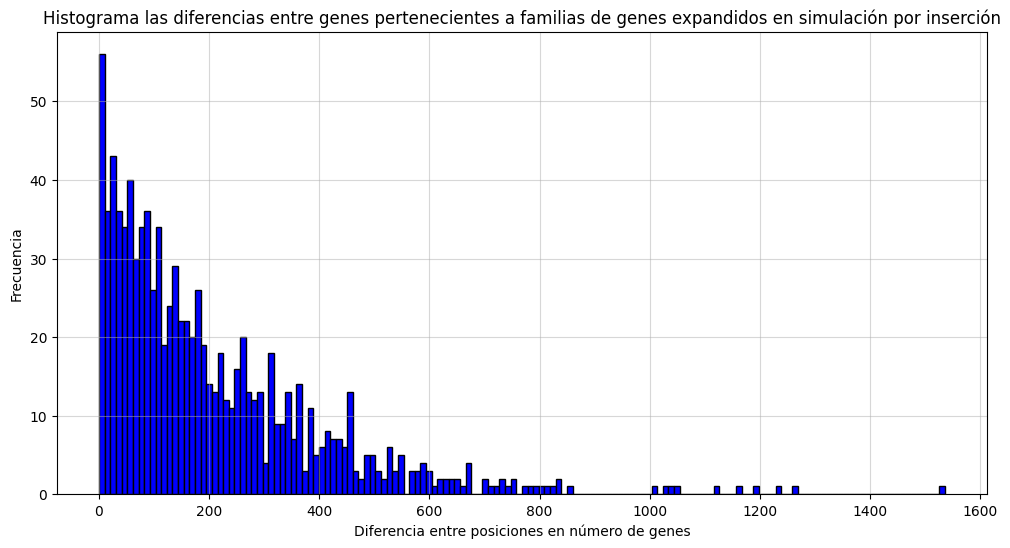

In [20]:
# Crear una lista con todas las diferencias
diferencias = [d for diferencias_genoma in resultados_diferencias_duplicados_insercion.values() for d in diferencias_genoma]


# Crear el histograma
plt.figure(figsize=(12, 6))
plt.hist(diferencias, bins=150, color='blue', edgecolor='black')
plt.title("Histograma las diferencias entre genes pertenecientes a familias de genes expandidos en simulación por inserción")
plt.xlabel("Diferencia entre posiciones en número de genes")
plt.ylabel("Frecuencia")
plt.grid(True, alpha=0.5)
plt.savefig('resultados_simulación/histograma_simulacion_insercion.png',dpi=150)
plt.show()

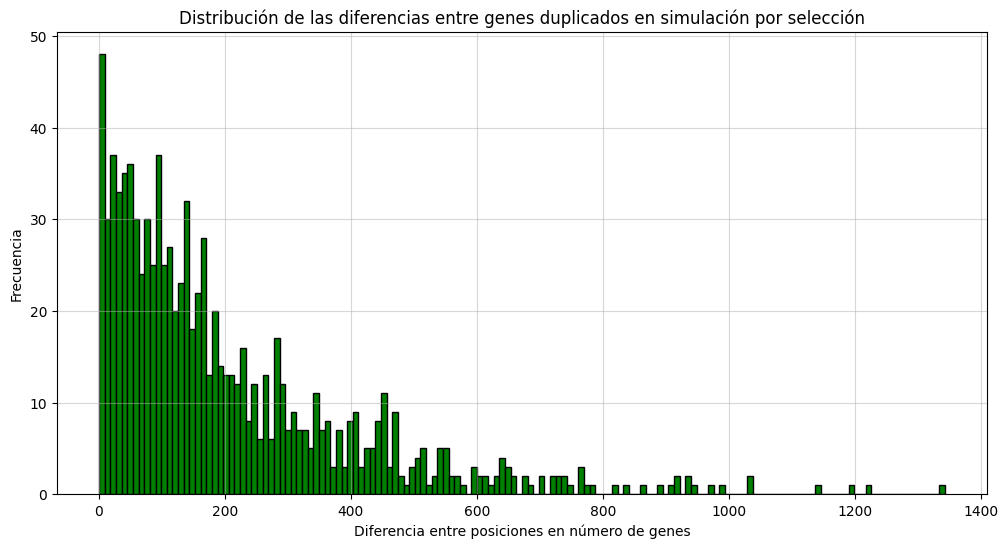

In [33]:
# Crear una lista con todas las diferencias
diferencias = [d for diferencias_genoma in resultados_diferencias_duplicados_seleccion.values() for d in diferencias_genoma]


# Crear el histograma
plt.figure(figsize=(12, 6))
plt.hist(diferencias, bins=150, color='green', edgecolor='black')
plt.title("Distribución de las diferencias entre genes duplicados en simulación por selección")
plt.xlabel("Diferencia entre posiciones en número de genes")
plt.ylabel("Frecuencia")
plt.grid(True, alpha=0.5)
plt.show()

## Ajustes por inserción


Resultados del ajuste (p-valor KS > 0.05):

Distribución          AIC        KS-Stat      KS-pvalue                    Parámetros
-------------------------------------------------------------------------------------
Exponencial      12095.18         0.0198         0.8403                1.000, 203.818
Weibull               inf         0.0246         0.6018         0.978, 3.000, 198.556


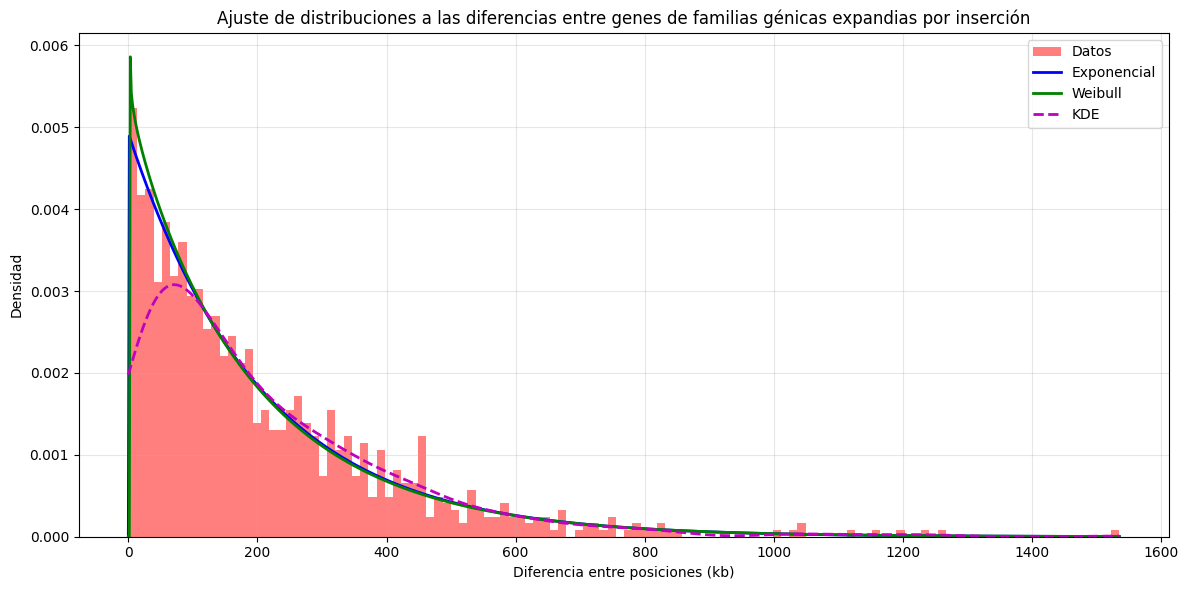

In [26]:
from scipy.stats import expon, gamma, lognorm, weibull_min, gaussian_kde, kstest
import numpy as np
import matplotlib.pyplot as plt

# Suponiendo que ya tienes esto:
diferencias = [d for diferencias_genoma in resultados_diferencias_duplicados_insercion.values() for d in diferencias_genoma]
datos_simulacion = np.array(diferencias)

# Rango para graficar
x = np.linspace(0, max(datos_simulacion), 1000)

# KDE
kde = gaussian_kde(datos_simulacion)
kde_pdf = kde(x)

# Diccionario de distribuciones a evaluar
distribuciones = {
    "Exponencial": expon,
    "Gamma": gamma,
    "Log-normal": lognorm,
    "Weibull": weibull_min
}

# Resultados
resultados = {}

# Evaluar cada distribución
for nombre, dist in distribuciones.items():
    try:
        params = dist.fit(datos_simulacion)
        pdf = dist.pdf(x, *params)
        loglik = np.sum(dist.logpdf(datos_simulacion, *params))
        k = len(params)
        aic = 2 * k - 2 * loglik
        ks_stat, ks_p = kstest(datos_simulacion, dist.name, args=params)

        # Filtrar solo si el p-valor > 0.05
        if ks_p > 0.05:
            resultados[nombre] = {
                "params": params,
                "pdf": pdf,
                "loglik": loglik,
                "aic": aic,
                "ks_stat": ks_stat,
                "ks_pvalue": ks_p
            }

    except Exception as e:
        print(f"Error con {nombre}: {e}")

# Imprimir tabla de resultados con p-valor > 0.05
print("\nResultados del ajuste (p-valor KS > 0.05):\n")
print(f"{'Distribución':<15}{'AIC':>10}{'KS-Stat':>15}{'KS-pvalue':>15}{'Parámetros':>30}")
print("-" * 85)
for nombre, res in resultados.items():
    params_str = ", ".join([f"{p:.3f}" for p in res['params']])
    print(f"{nombre:<15}{res['aic']:>10.2f}{res['ks_stat']:>15.4f}{res['ks_pvalue']:>15.4f}{params_str:>30}")

# Graficar
plt.figure(figsize=(12, 6))
plt.hist(datos_simulacion, bins=120, alpha=0.5, color='red', density=True, label='Datos')

# Graficar solo PDFs con p-valor > 0.05
colores = ['b', 'g', 'orange', 'purple']
for (nombre, res), color in zip(resultados.items(), colores):
    plt.plot(x, res['pdf'], label=f"{nombre}", lw=2, color=color)

# KDE
plt.plot(x, kde_pdf, 'm--', lw=2, label='KDE')

plt.title("Ajuste de distribuciones a las diferencias entre genes de familias génicas expandias por inserción")
plt.xlabel("Diferencia entre posiciones (kb)")
plt.ylabel("Densidad")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("resultados_simulación/ajuste_dist_diferencias_genes_insercion.png", dpi=150)
plt.show()


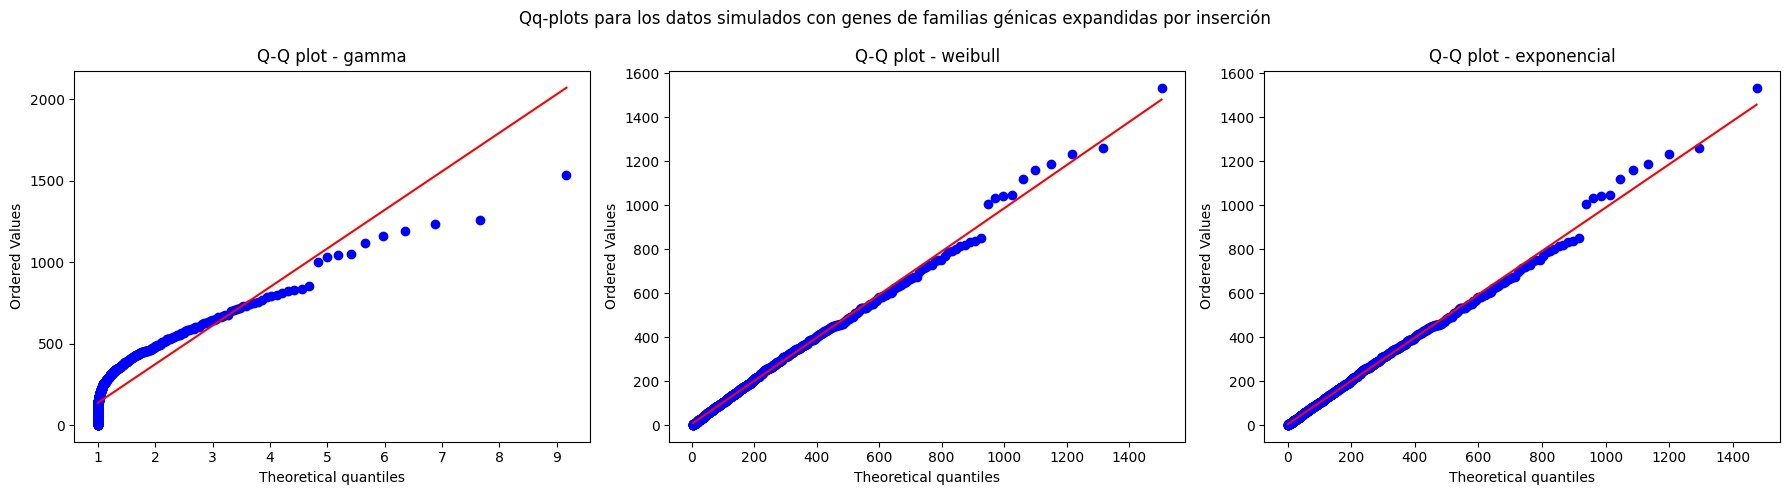

In [27]:
import matplotlib.pyplot as plt
from scipy import stats

# Ajustamos las tres distribuciones
params_gamma = stats.gamma.fit(datos_simulacion)
params_weibull = stats.weibull_min.fit(datos_simulacion)
params_expon = stats.expon.fit(datos_simulacion)

# Crear Q-Q plots para las tres distribuciones
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plt.suptitle('Qq-plots para los datos simulados con genes de familias génicas expandidas por inserción')
# weibull
stats.probplot(datos_simulacion, dist=stats.gamma, sparams=params_gamma, plot=axes[0])
axes[0].set_title("Q-Q plot - gamma")

# loggamma
stats.probplot(datos_simulacion, dist=stats.weibull_min, sparams=params_weibull, plot=axes[1])
axes[1].set_title("Q-Q plot - weibull")

# johnsonsu
stats.probplot(datos_simulacion, dist=stats.expon, sparams=params_expon, plot=axes[2])
axes[2].set_title("Q-Q plot - exponencial")

plt.tight_layout()
plt.savefig('resultados_simulación/qqplots_simulacion_insercion.png',dpi=200)
plt.show()

In [89]:
print("Parámetros gamma:", params_gamma)
print("Parámetros Weibull:", params_weibull)
print("Parámetros exponencial:", params_expon)

Parámetros gamma: (1.0404198591268692, 0.9482848257464137, 195.94961845340404)
Parámetros Weibull: (1.0440278484717265, 0.9396597227607294, 207.29701584405984)
Parámetros exponencial: (1.0, 203.8181818181818)



Resultados del ajuste:

Distribución          AIC        KS-Stat      KS-pvalue                    Parámetros
-------------------------------------------------------------------------------------
Exponencial      12085.76         0.0199         0.8346                1.000, 202.818
Gamma            12085.11         0.0228         0.6925         0.986, 1.000, 208.166
Log-normal       12161.72         0.0347         0.1937       0.944, -15.699, 146.864
Weibull          12086.46         0.0232         0.6730         0.992, 1.000, 204.986


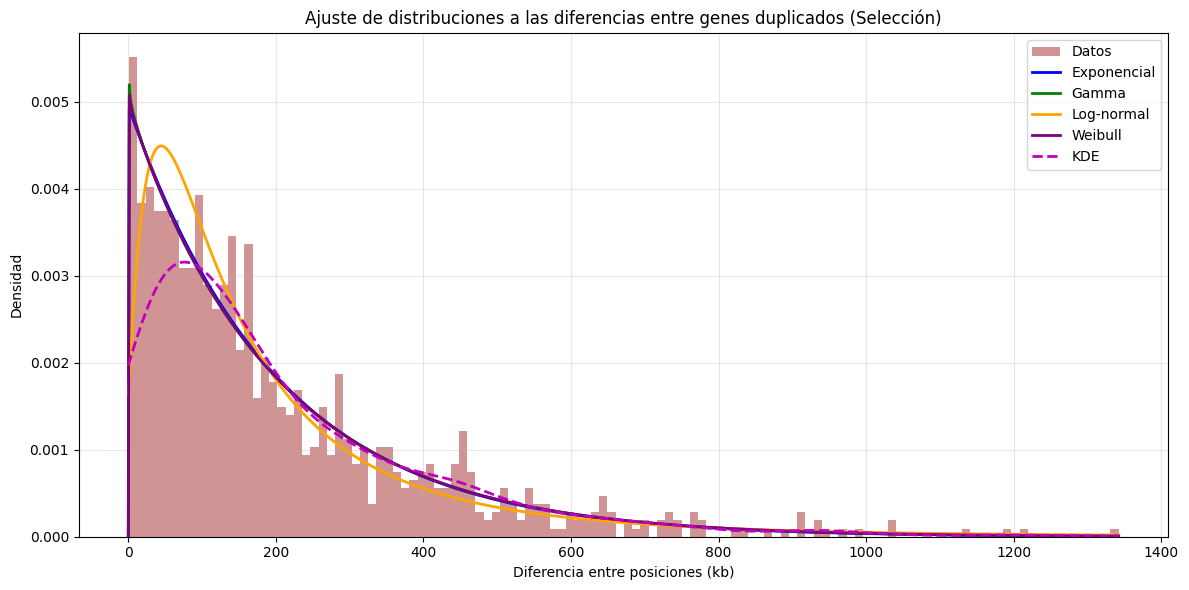

In [91]:
### ajustes por selección

from scipy.stats import expon, gamma, lognorm, weibull_min, gaussian_kde, kstest
# Suponiendo que ya tienes esto:
diferencias = [d for diferencias_genoma in resultados_diferencias_duplicados_seleccion.values() for d in diferencias_genoma]
datos_simulacion_seleccion = np.array(diferencias)

# Rango para graficar
x = np.linspace(0, max(datos_simulacion_seleccion), 1000)

# KDE
kde = gaussian_kde(datos_simulacion_seleccion)
kde_pdf = kde(x)

# Diccionario de distribuciones a evaluar
distribuciones = {
    "Exponencial": expon,
    "Gamma": gamma,
    "Log-normal": lognorm,
    "Weibull": weibull_min
}

# Resultados
resultados = {}

# Evaluar cada distribución
for nombre, dist in distribuciones.items():
    try:
        params = dist.fit(datos_simulacion_seleccion)
        pdf = dist.pdf(x, *params)
        loglik = np.sum(dist.logpdf(datos_simulacion_seleccion, *params))
        k = len(params)
        aic = 2 * k - 2 * loglik
        ks_stat, ks_p = kstest(datos_simulacion_seleccion, dist.name, args=params)

        resultados[nombre] = {
            "params": params,
            "pdf": pdf,
            "loglik": loglik,
            "aic": aic,
            "ks_stat": ks_stat,
            "ks_pvalue": ks_p
        }

    except Exception as e:
        print(f"Error con {nombre}: {e}")

# Imprimir tabla de resultados con parámetros
print("\nResultados del ajuste:\n")
print(f"{'Distribución':<15}{'AIC':>10}{'KS-Stat':>15}{'KS-pvalue':>15}{'Parámetros':>30}")
print("-" * 85)
for nombre, res in resultados.items():
    params_str = ", ".join([f"{p:.3f}" for p in res['params']])
    print(f"{nombre:<15}{res['aic']:>10.2f}{res['ks_stat']:>15.4f}{res['ks_pvalue']:>15.4f}{params_str:>30}")


# Graficar
plt.figure(figsize=(12, 6))
plt.hist(datos_simulacion_seleccion, bins=120, alpha=0.5, color='brown', density=True, label='Datos')

# Graficar cada PDF ajustada
colores = ['b', 'g', 'orange', 'purple']
#colores = ['white', 'white', 'white', 'white']
for (nombre, res), color in zip(resultados.items(), colores):
    plt.plot(x, res['pdf'], label=f"{nombre}", lw=2, color=color)

# Graficar KDE
plt.plot(x, kde_pdf, 'm--', lw=2, label='KDE')

plt.title("Ajuste de distribuciones a las diferencias entre genes duplicados (Selección)")
plt.xlabel("Diferencia entre posiciones (kb)")
plt.ylabel("Densidad")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("ajuste_dist_diferencias_genes_selección.png", dpi=300)
plt.show()

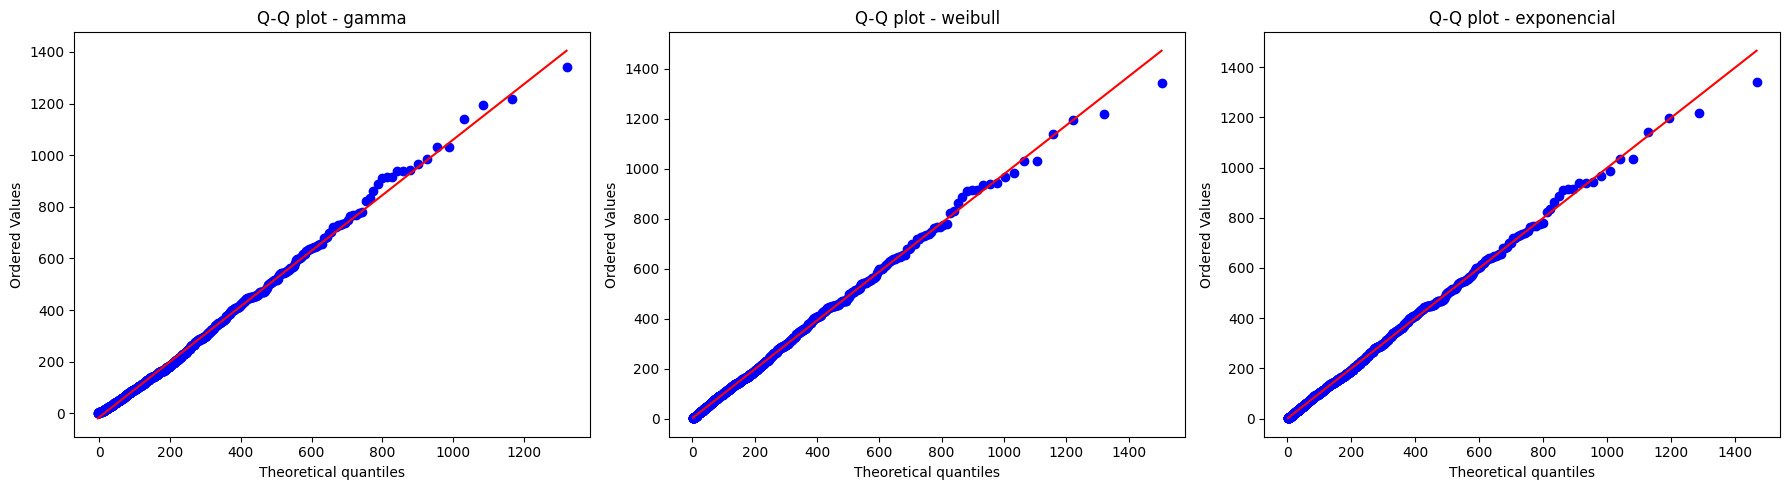

In [39]:
import matplotlib.pyplot as plt
from scipy import stats

# Ajustamos las tres distribuciones
params_gamma = stats.gamma.fit(datos_simulacion)
params_weibull = stats.weibull_min.fit(datos_simulacion_seleccion)
params_expon = stats.expon.fit(datos_simulacion_seleccion)

# Crear Q-Q plots para las tres distribuciones
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# weibull
stats.probplot(datos_simulacion_seleccion, dist=stats.gamma, sparams=params_gamma, plot=axes[0])
axes[0].set_title("Q-Q plot - gamma")

# loggamma
stats.probplot(datos_simulacion_seleccion, dist=stats.weibull_min, sparams=params_weibull, plot=axes[1])
axes[1].set_title("Q-Q plot - weibull")

# johnsonsu
stats.probplot(datos_simulacion_seleccion, dist=stats.expon, sparams=params_expon, plot=axes[2])
axes[2].set_title("Q-Q plot - exponencial")

plt.tight_layout()
plt.show()

In [40]:
print("Parámetros gamma:", params_gamma)
print("Parámetros Weibull:", params_weibull)
print("Parámetros exponencial:", params_expon)

Parámetros gamma: (1.2332065709899878, -5.097762985985936, 169.40867905834034)
Parámetros Weibull: (0.9923577443768903, 0.9999999999999998, 204.98560654627443)
Parámetros exponencial: (1.0, 202.8181818181818)


## Ajustes usando la transformación log

## insercion

/opt/tljh/user/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6554: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/opt/tljh/user/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/tljh/user/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


Resultados con KS p-valor > 0.05:

Distribución: gengamma
  AIC: 2984.30
  KS D: 0.0162
  KS p-valor: 0.9588

Distribución: loggamma
  AIC: 2984.79
  KS D: 0.0167
  KS p-valor: 0.9473

Distribución: johnsonsu
  AIC: 2987.24
  KS D: 0.0170
  KS p-valor: 0.9400

Distribución: weibull
  AIC: 2984.81
  KS D: 0.0183
  KS p-valor: 0.8997

Distribución: beta
  AIC: 2992.76
  KS D: 0.0232
  KS p-valor: 0.6744


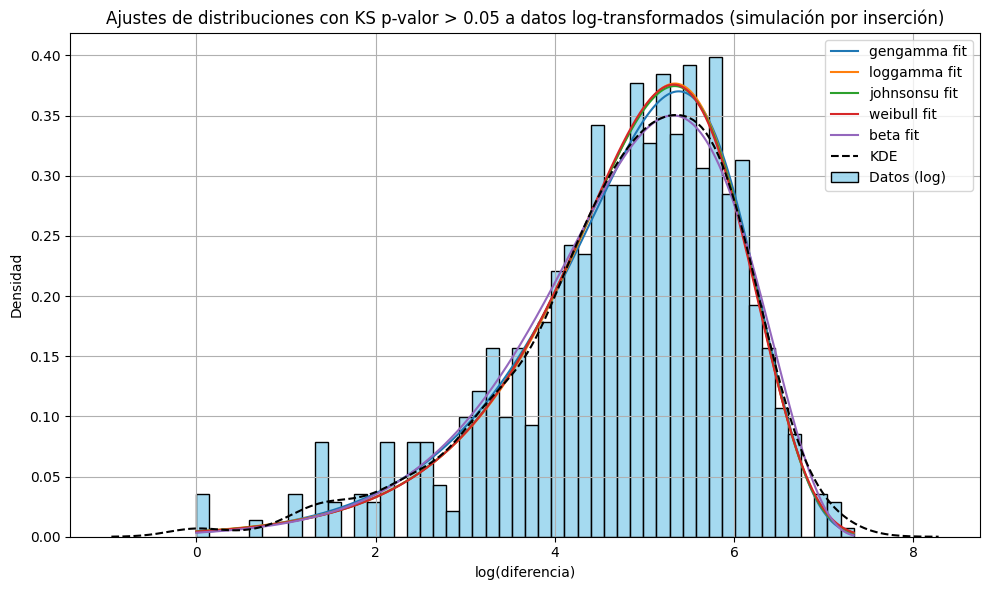

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Suponiendo que ya tienes definida la variable: datos_simulacion
log_diffs_simulacion = np.log(datos_simulacion)

# Diccionario de distribuciones
distribuciones = {
    'lognorm': stats.lognorm,
    'gamma': stats.gamma,
    'weibull': stats.weibull_min,
    'beta': stats.beta,
    'norm': stats.norm,
    'expon': stats.expon,
    'loggamma': stats.loggamma,
    'gengamma': stats.gengamma,
    'johnsonsu': stats.johnsonsu
}

# Almacenar resultados
resultados_simulacion = {}

for nombre, dist in distribuciones.items():
    try:
        params = dist.fit(log_diffs_simulacion)
        log_likelihood = np.sum(dist.logpdf(log_diffs_simulacion, *params))
        k = len(params)
        AIC = 2 * k - 2 * log_likelihood
        D, p_ks = stats.kstest(log_diffs_simulacion, dist.name, args=params)

        # Guardar solo si el p-valor es mayor a 0.05
        if p_ks > 0.05:
            resultados_simulacion[nombre] = {
                'params': params,
                'AIC': AIC,
                'KS D': D,
                'KS p-value': p_ks
            }
    except Exception as e:
        print(f"Error ajustando {nombre}: {e}")

# Mostrar solo resultados con p-valor > 0.05, ordenados por p-valor descendente
print("Resultados con KS p-valor > 0.05:")
for nombre in sorted(resultados_simulacion, key=lambda x: resultados_simulacion[x]['KS p-value'], reverse=True):
    res = resultados_simulacion[nombre]
    print(f"\nDistribución: {nombre}")
    print(f"  AIC: {res['AIC']:.2f}")
    print(f"  KS D: {res['KS D']:.4f}")
    print(f"  KS p-valor: {res['KS p-value']:.4f}")

# Preparar figura
plt.figure(figsize=(10, 6))
sns.histplot(log_diffs_simulacion, bins=50, kde=False, stat='density',
             color='skyblue', label='Datos (log)', edgecolor='black')

# Eje X para las curvas de densidad
x_vals = np.linspace(min(log_diffs_simulacion), max(log_diffs_simulacion), 1000)

# Graficar solo distribuciones válidas
for nombre in sorted(resultados_simulacion, key=lambda x: resultados_simulacion[x]['KS p-value'], reverse=True):
    dist = distribuciones[nombre]
    params = resultados_simulacion[nombre]['params']
    plt.plot(x_vals, dist.pdf(x_vals, *params), label=f'{nombre} fit')

# KDE para comparación
sns.kdeplot(log_diffs_simulacion, color='black', linestyle='--', label='KDE')

# Estética del gráfico
plt.title("Ajustes de distribuciones con KS p-valor > 0.05 a datos log-transformados (simulación por inserción)")
plt.xlabel("log(diferencia)")
plt.ylabel("Densidad")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("resultados_simulación/ajuste_distribuciones_con_log_simulacion_insercion.png", dpi=150)
plt.show()


Parámetros johson su: 4.012, 2.588, 7.649, 1.189
AIC: 12108.183608062234
KS Statistic: 0.01701880766196917
KS p-value: 0.93995531188562


/tmp/ipykernel_1395574/3315659819.py:14: RuntimeWarning: divide by zero encountered in log
  y = np.log(x)
/tmp/ipykernel_1395574/3315659819.py:15: RuntimeWarning: invalid value encountered in divide
  return johnsonsu.pdf(y, *params) / x


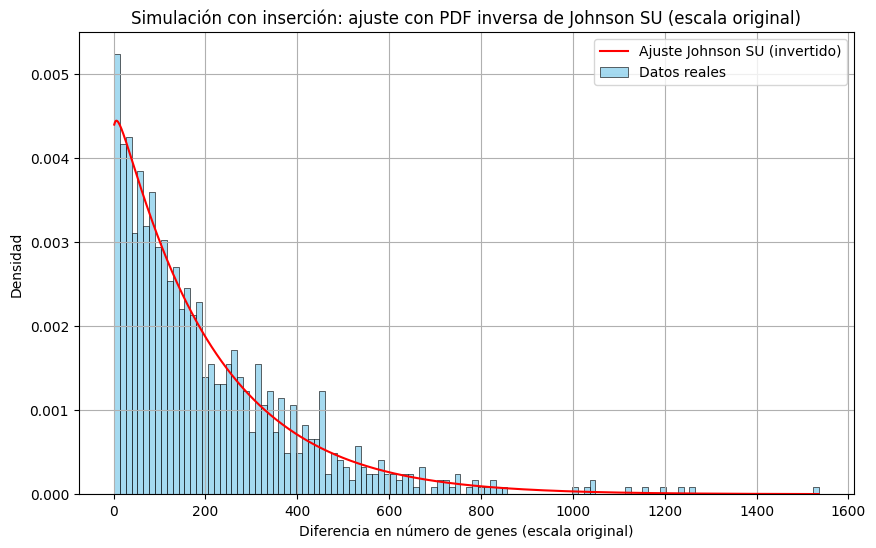

In [33]:
from scipy.stats import johnsonsu, kstest

# 1. Transformación de los datos
log_diffs = np.log(datos_simulacion)

# 2. Ajuste de la distribución Johnson SU en escala logarítmica
params = johnsonsu.fit(log_diffs_simulacion)
# 2. Ajuste de la distribución Johnson SU en escala logarítmica
params = johnsonsu.fit(log_diffs_simulacion)
print(f"Parámetros johson su: {', '.join(f'{p:.3f}' for p in params)}")

# 3. PDF y CDF en escala original (invirtiendo log1p)
def pdf_original(x):
    y = np.log(x)
    return johnsonsu.pdf(y, *params) / x

def cdf_original(x):
    y = np.log(x)
    return johnsonsu.cdf(y, *params)

# 4. AIC en escala original
log_probs = np.log(pdf_original(diferencias))
log_likelihood = np.sum(log_probs)
k = len(params)
aic = 2 * k - 2 * log_likelihood

# 5. Prueba KS en escala original
ks_stat, ks_p_value = kstest(datos_simulacion, cdf_original)

# 6. Resultados
print(f"AIC: {aic}")
print(f"KS Statistic: {ks_stat}")
print(f"KS p-value: {ks_p_value}")

# 7. Gráfico
x_vals = np.linspace(0, np.max(diferencias), 1000)
plt.figure(figsize=(10, 6))
sns.histplot(diferencias, bins=120, stat='density', color='skyblue', edgecolor='black', label='Datos reales')
plt.plot(x_vals, pdf_original(x_vals), color='red', label='Ajuste Johnson SU (invertido)')
plt.xlabel('Diferencia en número de genes (escala original)')
plt.ylabel('Densidad')
plt.title('Simulación con inserción: ajuste con PDF inversa de Johnson SU (escala original)')
plt.legend()
plt.grid(True)
plt.savefig("resultados_simulación/ajuste_distribuciones_simulacion_insercion_original_johnsonsu_inversa.png", dpi=150)
plt.show()


Parámetros loggamma: 0.964, 5.376, 0.956
AIC: 12105.732522981278
KS Statistic: 0.016735499004979948
KS p-value: 0.947321653409834


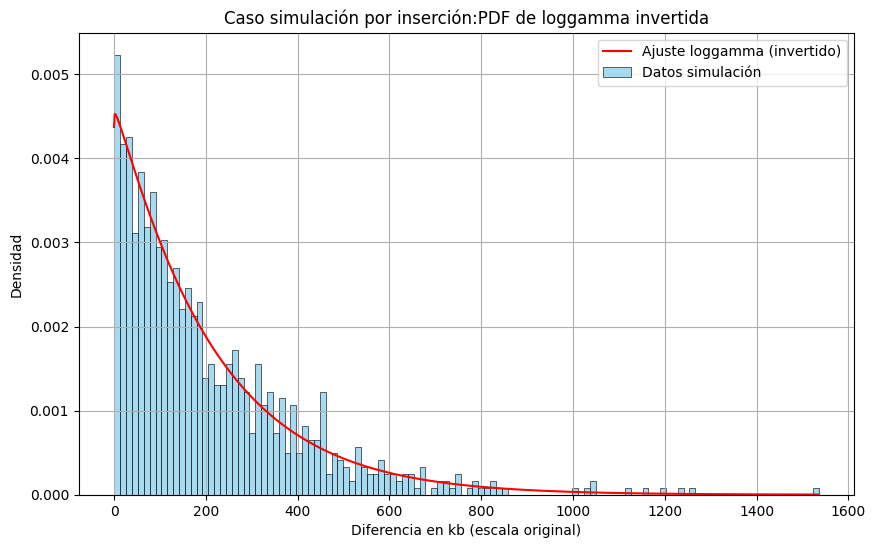

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import loggamma, kstest

# Asegurarse de que los datos sean un array de NumPy
datos_simulacion = np.array(datos_simulacion)

# 1. Transformación logarítmica (solo valores positivos)
datos_positivos = datos_simulacion[datos_simulacion > 0]
logg_diffs_simulacion = np.log(datos_positivos)

# 2. Ajuste de loggamma en escala logarítmica
params = loggamma.fit(logg_diffs_simulacion)
print(f"Parámetros loggamma: {', '.join(f'{p:.3f}' for p in params)}")

# 3. PDF y CDF en escala original (invirtiendo log)
def pdf_original(x):
    y = np.log(x)
    return loggamma.pdf(y, *params) / x

def cdf_original(x):
    y = np.log(x)
    return loggamma.cdf(y, *params)

# 4. AIC en escala original
log_probs = np.log(pdf_original(datos_positivos))
log_likelihood = np.sum(log_probs)
k = len(params)
aic = 2 * k - 2 * log_likelihood

# 5. Prueba KS en escala original
ks_stat, ks_p_value = kstest(datos_positivos, cdf_original)

# 6. Resultados
print(f"AIC: {aic}")
print(f"KS Statistic: {ks_stat}")
print(f"KS p-value: {ks_p_value}")

# 7. Gráfico
x_vals = np.linspace(0.01, np.max(datos_positivos), 1000)  # evitar log(0)
plt.figure(figsize=(10, 6))
sns.histplot(datos_positivos, bins=120, stat='density', color='skyblue', edgecolor='black', label='Datos simulación')
plt.plot(x_vals, pdf_original(x_vals), color='red', label='Ajuste loggamma (invertido)')
plt.xlabel('Diferencia en kb (escala original)')
plt.ylabel('Densidad')
plt.title('Caso simulación por inserción:PDF de loggamma invertida')
plt.legend()
plt.grid(True)
plt.savefig("resultados_simulación/ajuste_distribuciones_simulacion_insercion_original_inversa_loggamma.png", dpi=150)
plt.show()
plt.show()


In [45]:
%autosave 30

Autosaving every 30 seconds


## transformacion de datos bajo log (simulación por selección)

/opt/tljh/user/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6554: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/opt/tljh/user/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/tljh/user/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


Resultados con KS p-valor > 0.05:

Distribución: weibull
  AIC: 2981.45
  KS D: 0.0190
  KS p-valor: 0.8738
  Parámetros: 45.074, -39.240, 44.553

Distribución: johnsonsu
  AIC: 2983.30
  KS D: 0.0197
  KS p-valor: 0.8439
  Parámetros: 8.360, 3.071, 8.434, 0.460

Distribución: loggamma
  AIC: 2981.90
  KS D: 0.0201
  KS p-valor: 0.8250
  Parámetros: 1.121, 5.177, 1.052

Distribución: beta
  AIC: 2983.79
  KS D: 0.0241
  KS p-valor: 0.6274
  Parámetros: 1713212.826, 5.145, -927955.099, 927962.646


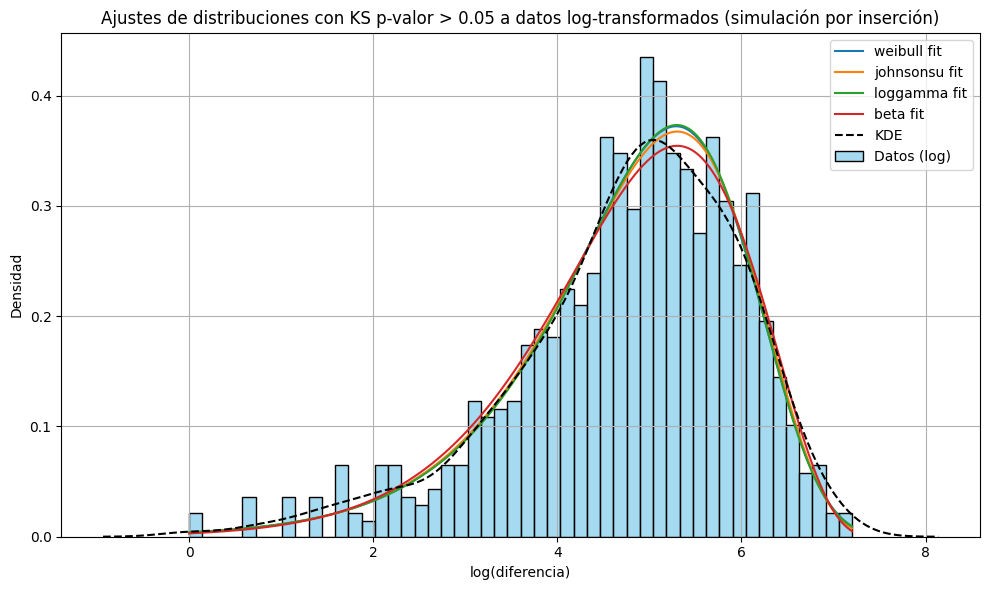

In [93]:
# Suponiendo que ya tienes definida la variable: datos_simulacion
log_diffs_simulacion_seleccion = np.log(datos_simulacion_seleccion)

# Diccionario de distribuciones
distribuciones = {
    'lognorm': stats.lognorm,
    'gamma': stats.gamma,
    'weibull': stats.weibull_min,
    'beta': stats.beta,
    'norm': stats.norm,
    'expon': stats.expon,
    'loggamma': stats.loggamma,
    'gengamma': stats.gengamma,
    'johnsonsu': stats.johnsonsu
}

# Almacenar resultados
resultados_simulacion = {}

for nombre, dist in distribuciones.items():
    try:
        params = dist.fit(log_diffs_simulacion_seleccion)
        log_likelihood = np.sum(dist.logpdf(log_diffs_simulacion_seleccion, *params))
        k = len(params)
        AIC = 2 * k - 2 * log_likelihood
        D, p_ks = stats.kstest(log_diffs_simulacion_seleccion, dist.name, args=params)

        # Guardar solo si el p-valor es mayor a 0.05
        if p_ks > 0.05:
            resultados_simulacion[nombre] = {
                'params': params,
                'AIC': AIC,
                'KS D': D,
                'KS p-value': p_ks
            }
    except Exception as e:
        print(f"Error ajustando {nombre}: {e}")

# Mostrar solo resultados con p-valor > 0.05, ordenados por p-valor descendente
print("Resultados con KS p-valor > 0.05:")
for nombre in sorted(resultados_simulacion, key=lambda x: resultados_simulacion[x]['KS p-value'], reverse=True):
    res = resultados_simulacion[nombre]
    params_str = ', '.join([f"{p:.3f}" for p in res['params']])
    print(f"\nDistribución: {nombre}")
    print(f"  AIC: {res['AIC']:.2f}")
    print(f"  KS D: {res['KS D']:.4f}")
    print(f"  KS p-valor: {res['KS p-value']:.4f}")
    print(f"  Parámetros: {params_str}")

# Preparar figura
plt.figure(figsize=(10, 6))
sns.histplot(log_diffs_simulacion_seleccion, bins=50, kde=False, stat='density',
             color='skyblue', label='Datos (log)', edgecolor='black')

# Eje X para las curvas de densidad
x_vals = np.linspace(min(log_diffs_simulacion_seleccion), max(log_diffs_simulacion_seleccion), 1000)

# Graficar solo distribuciones válidas
for nombre in sorted(resultados_simulacion, key=lambda x: resultados_simulacion[x]['KS p-value'], reverse=True):
    dist = distribuciones[nombre]
    params = resultados_simulacion[nombre]['params']
    plt.plot(x_vals, dist.pdf(x_vals, *params), label=f'{nombre} fit')

# KDE para comparación
sns.kdeplot(log_diffs_simulacion_seleccion, color='black', linestyle='--', label='KDE')

# Estética del gráfico
plt.title("Ajustes de distribuciones con KS p-valor > 0.05 a datos log-transformados (simulación por inserción)")
plt.xlabel("log(diferencia)")
plt.ylabel("Densidad")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("ajuste_distribuciones_simulacion_seleccion.png", dpi=300)
plt.show()



In [ ]:
print("Parámetros johson su:", params_)
print("Parámetros Weibull:", params_weibull)
print("Parámetros exponencial:", params_expon)

Parámetros weibull: 45.074, -39.240, 44.553
AIC: 12095.79
KS D: 0.0190
KS p-valor: 0.8738


/tmp/ipykernel_596162/3574275103.py:11: RuntimeWarning: divide by zero encountered in log
  y = np.log(x)
/tmp/ipykernel_596162/3574275103.py:12: RuntimeWarning: invalid value encountered in divide
  return weibull_min.pdf(y, *params) / x


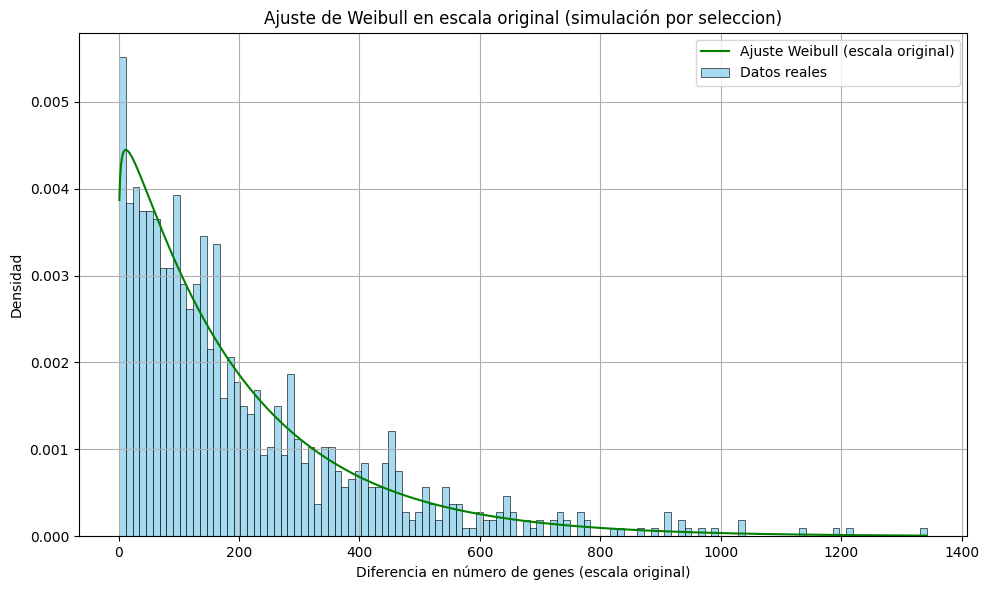

In [99]:
from scipy.stats import weibull_min, kstest

# 1. Transformación logarítmica (por consistencia con otros análisis, aunque no se usa aquí directamente)
log_diffs_simulacion_seleccion = np.log(datos_simulacion_seleccion)

# 2. Ajuste de la distribución Weibull en escala original
params = weibull_min.fit(log_diffs_simulacion_seleccion)
print(f"Parámetros weibull: {', '.join(f'{p:.3f}' for p in params)}")
# 3. PDF y CDF en escala original (no se necesita invertir log)
def pdf_escala_original(x):
    y = np.log(x)
    return weibull_min.pdf(y, *params) / x

def cdf_escala_original(x):
    y = np.log(x)
    return weibull_min.cdf(y, *params)

# 4. AIC en escala original
log_probs = np.log(pdf_weibull(datos_simulacion_seleccion))
log_likelihood = np.sum(log_probs)
k = len(params)
aic = 2 * k - 2 * log_likelihood

# 5. Prueba KS en escala original
ks_stat, ks_p_value = kstest(datos_simulacion_seleccion, cdf_weibull)

# 6. Resultados
print(f"AIC: {aic:.2f}")
print(f"KS D: {ks_stat:.4f}")
print(f"KS p-valor: {ks_p_value:.4f}")

# 7. Gráfico
x_vals = np.linspace(0, np.max(datos_simulacion_seleccion), 1000)

plt.figure(figsize=(10, 6))
sns.histplot(datos_simulacion_seleccion, bins=120, stat='density', color='skyblue', edgecolor='black', label='Datos reales')
plt.plot(x_vals, pdf_weibull(x_vals), color='green', label='Ajuste Weibull (escala original)')
plt.xlabel('Diferencia en número de genes (escala original)')
plt.ylabel('Densidad')
plt.title('Ajuste de Weibull en escala original (simulación por seleccion)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("ajuste_distribuciones_simulacion_seleccion_original_weibull.png", dpi=300)
plt.show()

Parámetros johsonsu: 8.360, 3.071, 8.434, 0.460

AIC: 12097.64
KS D: 0.0197
KS p-valor: 0.8439


/tmp/ipykernel_596162/2352404768.py:11: RuntimeWarning: divide by zero encountered in log
  y = np.log(x)
/tmp/ipykernel_596162/2352404768.py:12: RuntimeWarning: invalid value encountered in divide
  return johnsonsu.pdf(y, *params) / x


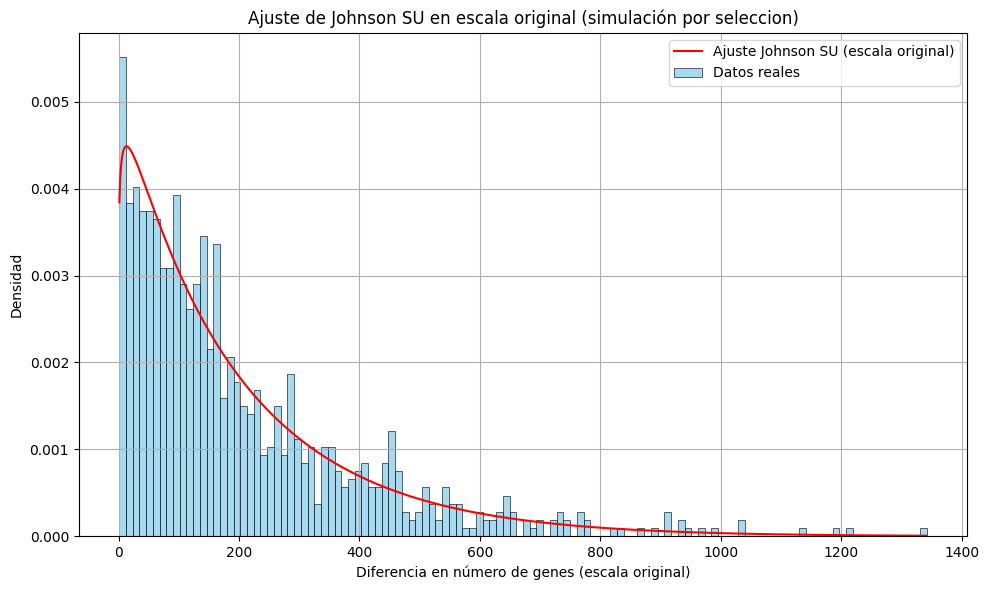

In [100]:
from scipy.stats import johnsonsu, kstest

# 1. Transformación logarítmica
log_diffs_simulacion_seleccion = np.log(datos_simulacion_seleccion)

# 2. Ajuste de Johnson SU a los datos log-transformados
params = johnsonsu.fit(log_diffs_simulacion_seleccion)
print(f"Parámetros johsonsu: {', '.join(f'{p:.3f}' for p in params)}")
# 3. PDF y CDF en escala original (invirtiendo el log)
def pdf_escala_original(x):
    y = np.log(x)
    return johnsonsu.pdf(y, *params) / x

def cdf_escala_original(x):
    y = np.log(x)
    return johnsonsu.cdf(y, *params)

# 4. AIC en escala original
log_probs = np.log(pdf_escala_original(datos_simulacion_seleccion))
log_likelihood = np.sum(log_probs)
k = len(params)
aic = 2 * k - 2 * log_likelihood

# 5. Prueba KS en escala original
ks_stat, ks_p_value = kstest(datos_simulacion_seleccion, cdf_escala_original)

# 6. Resultados
print()
print(f"AIC: {aic:.2f}")
print(f"KS D: {ks_stat:.4f}")
print(f"KS p-valor: {ks_p_value:.4f}")

# 7. Gráfico
x_vals = np.linspace(0, np.max(datos_simulacion_seleccion), 1000)

plt.figure(figsize=(10, 6))
sns.histplot(datos_simulacion_seleccion, bins=120, stat='density', color='skyblue', edgecolor='black', label='Datos reales')
plt.plot(x_vals, pdf_escala_original(x_vals), color='red', label='Ajuste Johnson SU (escala original)')
plt.xlabel('Diferencia en número de genes (escala original)')
plt.ylabel('Densidad')
plt.title('Ajuste de Johnson SU en escala original (simulación por seleccion)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("ajuste_distribuciones_simulacion_seleccion_original_johnsonsu.png", dpi=300)
plt.show()
Parámetros weibull: 45.074, -39.240, 44.553
AIC: 12095.79
KS D: 0.0190
KS p-valor: 0.8738


Parámetros loggamma: 1.121, 5.177, 1.052
AIC: 12096.24
KS D: 0.0201
KS p-valor: 0.8250


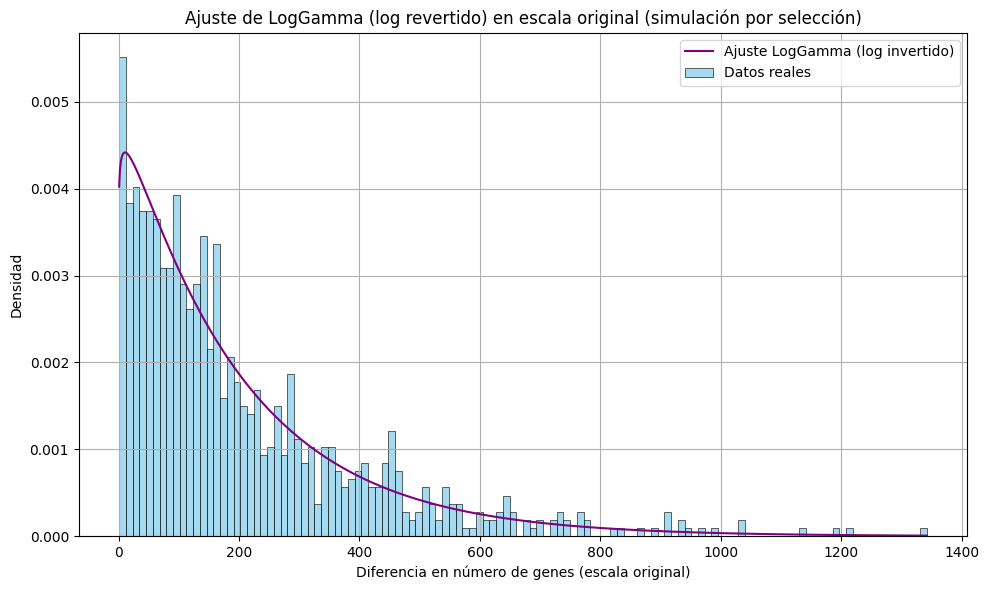

In [101]:
from scipy.stats import loggamma, kstest
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Transformación logarítmica
log_diffs_simulacion_seleccion = np.log(datos_simulacion_seleccion)

# 2. Ajuste de la distribución loggamma a los datos log-transformados
params = loggamma.fit(log_diffs_simulacion_seleccion)
print(f"Parámetros loggamma: {', '.join(f'{p:.3f}' for p in params)}")
# 3. PDF y CDF en escala original (revirtiendo el log)
def pdf_escala_original(x):
    y = np.log(x)
    return loggamma.pdf(y, *params) / x

def cdf_escala_original(x):
    y = np.log(x)
    return loggamma.cdf(y, *params)

# 4. AIC en escala original
log_probs = np.log(pdf_escala_original(datos_simulacion_seleccion))
log_likelihood = np.sum(log_probs)
k = len(params)
aic = 2 * k - 2 * log_likelihood

# 5. Prueba KS en escala original
ks_stat, ks_p_value = kstest(datos_simulacion_seleccion, cdf_escala_original)

# 6. Resultados
print(f"AIC: {aic:.2f}")
print(f"KS D: {ks_stat:.4f}")
print(f"KS p-valor: {ks_p_value:.4f}")

# 7. Gráfico
x_vals = np.linspace(min(datos_simulacion_seleccion), max(datos_simulacion_seleccion), 1000)

plt.figure(figsize=(10, 6))
sns.histplot(datos_simulacion_seleccion, bins=120, stat='density',
             color='skyblue', edgecolor='black', label='Datos reales')
plt.plot(x_vals, pdf_escala_original(x_vals), color='purple', label='Ajuste LogGamma (log invertido)')
plt.xlabel('Diferencia en número de genes (escala original)')
plt.ylabel('Densidad')
plt.title('Ajuste de LogGamma (log revertido) en escala original (simulación por selección)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("ajuste_distribuciones_simulacion_seleccion_original_loggamma_logrevertido.png", dpi=300)
plt.show()
